In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

C:\Users\A0778513\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\A0778513\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

In [110]:
import wikipedia
monalisa = wikipedia.page('Mona Lisa')
#pyth = wikipedia.page('Python Programming Language')
covid = wikipedia.page('Covid-19 Pandemic')
ds = wikipedia.page('Data Science')

In [111]:
corpus = [monalisa.content,covid.content,ds.content]

### Processing Text - Remove Special Characters, #Sign, Punctuation and change it to lowercase.

In [112]:
def remove_pattern(input_text,pattern):
    r = re.findall(pattern,input_text)
    for word in r:
        input_text = re.sub(word,"",input_text)
    return input_text

def l_case():
    for x in df['clean_tweet']:
        x.lowercase()
        
def remove_breakline(input_text,pattern):
    r = re.findall(pattern,input_text)
    for word in r:
        input_text = re.sub(word,"",input_text)
    return input_text

In [114]:
import re
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(document):
    document = re.sub(r'\W',' ',str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+',' ',document)
    document = re.sub(r'\^[a-zA-Z]\s+',' ',document)
    document = re.sub(r'\s+',' ',document, flags=re.I)
    document = re.sub(r'^b\s+','',document)
    document = document.lower()
    
    tokens = document.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    return tokens
    
processed_data = []
for doc in corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A0778513\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Subjectivity & Polarity Score

In [115]:
from textblob import TextBlob
# Create a function to get the subjectivity
def getSubjectivity(text):
    print ('Subjectivity of this sentence is',TextBlob(text).sentiment.subjectivity)

# Create a function to get the polarity
def getPolarity(text):
    print ('Polarity Score of this sentence is',TextBlob(text).sentiment.polarity)


getSubjectivity(corpus[0])
getPolarity(corpus[0])

Subjectivity of this sentence is 0.37982076941426535
Polarity Score of this sentence is 0.09526920384643968


### List of Positive & Negative Words

In [35]:
#List of Tokenized Words
#Tokenize words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
tw = word_tokenize(corpus,"english")
Posivite_wrds = []
Negative_wrds = []
Neutral_wrds =  []
sv = SentimentIntensityAnalyzer()
for sent in corpus:
    for word in sent:
        score = sv.polarity_scores(word)
        neg = score['neg']
        pos = score['pos']
        if pos>neg:
            Posivite_wrds.append(word)
        elif neg > pos:
            Negative_wrds.append(word)
        else:
            Neutral_wrds.append(word)

print(Posivite_wrds[:5])
print(Negative_wrds[:5])
print(Neutral_wrds[:5])

TypeError: expected string or bytes-like object

In [116]:
def sentiment_analyses(sentiment_text):
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    neg = score['neg']
    pos = score['pos']
    if neg>pos:
        return 'negative'
    elif pos > neg:
        return 'positive'
    else:
        return 'neutral'

In [117]:
a = sentiment_analyses(corpus[0])
print(f'It is a {a} statement.')

It is a positive statement.


### Topic Modeling 

In [118]:
import numpy
from gensim import corpora
import gensim
#Tokenize words
from nltk import word_tokenize
# newsent = [[x] for x in sentences]
# tokenize_words = [word_tokenize(sentences[0],"english")]


input_dict = corpora.Dictionary(processed_data)
doc_term_matrix = [input_dict.doc2bow(token,allow_update = True) for token in processed_data]
# input_corpus = (input_dict.doc2bow(token,allow_update=True) for token in tokenize_words)

In [119]:
lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix,num_topics=3,id2word=input_dict,passes=20,chunksize=1000,update_every=1)

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

In [123]:
lda_model.print_topics(num_words=9)

[(0,
  '0.013*"19" + 0.013*"2020" + 0.012*"covid" + 0.011*"case" + 0.010*"wa" + 0.008*"country" + 0.007*"reported" + 0.007*"pandemic" + 0.006*"people"'),
 (1,
  '0.022*"painting" + 0.021*"wa" + 0.019*"lisa" + 0.018*"mona" + 0.011*"leonardo" + 0.007*"ha" + 0.006*"louvre" + 0.006*"portrait" + 0.005*"work"'),
 (2,
  '0.037*"data" + 0.021*"science" + 0.010*"statistic" + 0.005*"used" + 0.004*"field" + 0.004*"technique" + 0.003*"new" + 0.003*"name" + 0.003*"knowledge"')]

### LDA Model Accuracy

In [124]:
print('Perplexity', lda_model.log_perplexity(doc_term_matrix,total_docs = 3))

from gensim.models.coherencemodel import CoherenceModel
coherencemodel_lda = CoherenceModel(model=lda_model,texts=processed_data,dictionary = input_dict,coherence='c_v' )
coherence_lda = coherencemodel_lda.get_coherence()
print('Coherence',coherence_lda)

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

Perplexity -7.529156654204428
Coherence 0.6986040113311945


In [126]:
def compute_coherence_val(doc_term_matrix,texts,dictionary,start,end):
    model_list = []
    coherence_values = []
    for i in range(start,end):
        model_ = gensim.models.ldamodel.LdaModel(doc_term_matrix,num_topics=i,id2word=dictionary,passes=20,chunksize=1000,update_every=1)
        coherencemodel_lda = CoherenceModel(model=model_,texts=texts,dictionary = dictionary,coherence='c_v' )
        coherence_lda = coherencemodel_lda.get_coherence()
        model_list.append(i)
        coherence_values.append(coherence_lda)
    return model_list, coherence_values



In [127]:
top,coh = compute_coherence_val(doc_term_matrix,processed_data,input_dict,2,11)

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\A0778513\anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbet

In [128]:
top

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [129]:
coh

[0.39190028755759354,
 0.47880077231550994,
 0.6542161732050904,
 0.5758996022582381,
 0.5676193945305802,
 0.44165171358494215,
 0.4839069357415128,
 0.47960337549556736,
 0.47739616422967546]

In [86]:


# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values
# model_list, coherence_values = compute_coherence_values(dictionary=input_dict, corpus=doc_term_matrix, texts=processed_data, start=2, limit=10, step=1)

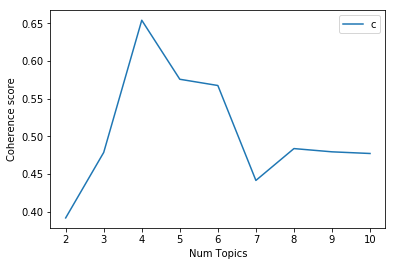

In [130]:
#Show graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coh)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [131]:
# Print the coherence scores
for m, cv in zip(x, coh):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3919
Num Topics = 3  has Coherence Value of 0.4788
Num Topics = 4  has Coherence Value of 0.6542
Num Topics = 5  has Coherence Value of 0.5759
Num Topics = 6  has Coherence Value of 0.5676
Num Topics = 7  has Coherence Value of 0.4417
Num Topics = 8  has Coherence Value of 0.4839
Num Topics = 9  has Coherence Value of 0.4796
Num Topics = 10  has Coherence Value of 0.4774


### Visualizing LDA Model

In [133]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, doc_term_matrix, input_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.144258 -0.040092       1        1  68.833331
1      0.123472 -0.064438       2        1  25.312269
2      0.020786  0.104530       3        1   5.854400, topic_info=            Term        Freq       Total Category  logprob  loglift
2068        data   38.000000   38.000000  Default  30.0000  30.0000
976     painting   69.000000   69.000000  Default  29.0000  29.0000
800         lisa   59.000000   59.000000  Default  28.0000  28.0000
892         mona   54.000000   54.000000  Default  27.0000  27.0000
1444          wa  150.000000  150.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1315      system    1.210976   11.152566   Topic3  -6.3836   0.6177
416    described    1.210870    6.168782   Topic3  -6.3837   1.2098
318   collection    1.210682    4.902796   Topic3  -6.3839   1.4394
2476      impact    1.210677    8.700211   Topic3  -6.3839   0.8658
3393        term    1.210662    6.959599   Topic3  -6.3839   1.0890

[181 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1508      1  0.999397      0
0         1  0.965510    000
0         2  0.040230    000
2         1  0.953358      1
2         2  0.028040      1
...     ...       ...    ...
1483      2  0.189950  world
3567      1  0.989347  wuhan
1493      1  0.600998   year
1493      2  0.350582   year
1493      3  0.050083   year

[227 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])